In [1]:
import os
import clang
from clang.cindex import *
from copy import deepcopy

In [2]:
# clang.cindex.Config.set_library_file('/usr/lib/x86_64-linux-gnu/libclang-14.so.14.0.0')
# Config.set_library_file("/usr/lib/x86_64-linux-gnu/libLLVM-14.so.1")
# Config.set_library_file("/usr/lib/x86_64-linux-gnu/libstdc++.so.6")
Config.set_library_file("C:\\Users\\Hp\\anaconda3\\envs\\tf\\Lib\\site-packages\\clang\\native\\libclang.dll")

In [3]:
# create an index and parse the source code
index = Index.create()
root_cursor = index.parse("main.c").cursor
# root_cursor = index.parse("/home/dipu/Documents/AI/MinorProject/c-corpus/cleaned/gno/lib/libc/tests/sys/rename.c").cursor

In [4]:
def print_ast(node, indent):
    try:
        print(" "*indent + node.spelling + " " + str(node.kind) + " " + str(node.type.spelling))
        for c in node.get_children():
            print_ast(c, indent+2)
    except ValueError:
        pass

print_ast(root_cursor, 0)

main.c CursorKind.TRANSLATION_UNIT 
  uintptr_t CursorKind.TYPEDEF_DECL uintptr_t
  va_list CursorKind.TYPEDEF_DECL va_list
  __va_start CursorKind.FUNCTION_DECL void (char **, ...)
     CursorKind.PARM_DECL va_list *
      va_list CursorKind.TYPE_REF va_list
  size_t CursorKind.TYPEDEF_DECL size_t
  ptrdiff_t CursorKind.TYPEDEF_DECL ptrdiff_t
  intptr_t CursorKind.TYPEDEF_DECL intptr_t
  __vcrt_bool CursorKind.TYPEDEF_DECL __vcrt_bool
  wchar_t CursorKind.TYPEDEF_DECL wchar_t
  __security_init_cookie CursorKind.FUNCTION_DECL void (void)
  __security_check_cookie CursorKind.FUNCTION_DECL void (uintptr_t)
    _StackCookie CursorKind.PARM_DECL uintptr_t
      uintptr_t CursorKind.TYPE_REF uintptr_t
  __report_gsfailure CursorKind.FUNCTION_DECL void (uintptr_t) __attribute__((noreturn))
    _StackCookie CursorKind.PARM_DECL uintptr_t
      uintptr_t CursorKind.TYPE_REF uintptr_t
  __security_cookie CursorKind.VAR_DECL uintptr_t
    uintptr_t CursorKind.TYPE_REF uintptr_t
  __crt_bool Curs

          _Result CursorKind.UNEXPOSED_EXPR int
            _Result CursorKind.DECL_REF_EXPR const int
  _vscwprintf_p CursorKind.FUNCTION_DECL int (const wchar_t *const, va_list)
    _Format CursorKind.PARM_DECL const wchar_t *const
      wchar_t CursorKind.TYPE_REF wchar_t
    _ArgList CursorKind.PARM_DECL va_list
      va_list CursorKind.TYPE_REF va_list
     CursorKind.COMPOUND_STMT 
       CursorKind.RETURN_STMT 
        _vscwprintf_p_l CursorKind.CALL_EXPR int
          _vscwprintf_p_l CursorKind.UNEXPOSED_EXPR int (*)(const wchar_t *const, const _locale_t, va_list) __attribute__((cdecl))
            _vscwprintf_p_l CursorKind.DECL_REF_EXPR int (const wchar_t *const, const _locale_t, va_list)
          _Format CursorKind.UNEXPOSED_EXPR const wchar_t *
            _Format CursorKind.DECL_REF_EXPR const wchar_t *const
           CursorKind.UNEXPOSED_EXPR _locale_t
             CursorKind.PAREN_EXPR void *
               CursorKind.CSTYLE_CAST_EXPR void *
                 CursorKind

    _Stream CursorKind.PARM_DECL FILE *const
      FILE CursorKind.TYPE_REF FILE
    _Format CursorKind.PARM_DECL const char *const
    _Locale CursorKind.PARM_DECL const _locale_t
      _locale_t CursorKind.TYPE_REF _locale_t
     CursorKind.COMPOUND_STMT 
       CursorKind.DECL_STMT 
        _Result CursorKind.VAR_DECL int
       CursorKind.DECL_STMT 
        _ArgList CursorKind.VAR_DECL va_list
          va_list CursorKind.TYPE_REF va_list
       CursorKind.PAREN_EXPR void
         CursorKind.CSTYLE_CAST_EXPR void
           CursorKind.PAREN_EXPR void
            __va_start CursorKind.CALL_EXPR void
              __va_start CursorKind.UNEXPOSED_EXPR void (*)(char **, ...)
                __va_start CursorKind.DECL_REF_EXPR <builtin fn type>
               CursorKind.UNARY_OPERATOR va_list *
                _ArgList CursorKind.DECL_REF_EXPR va_list
              _Locale CursorKind.DECL_REF_EXPR const _locale_t
       CursorKind.BINARY_OPERATOR int
        _Result CursorKind.DECL_REF_

In [5]:
def get_function_params(node, function_name, result):
    try:
        if node.kind == CursorKind.FUNCTION_DECL and node.spelling == function_name:
            for c in node.get_children():
                if c.kind == CursorKind.PARM_DECL:
                    # print(c.spelling + " " + str(c.kind) + " " + str(c.type.spelling))
                    result.append({"name": c.spelling, "data_type": c.type.spelling})
            return
    except ValueError:
        pass

    for c in node.get_children():
        get_function_params(c, function_name, result)

In [6]:
param_list = []
get_function_params(root_cursor, "getSum", param_list)
param_list

[]

In [7]:
def get_called_functions(root, node, result):
    try:
        if node.kind == CursorKind.CALL_EXPR:
            # "location": node.extent
            current_function = {"name": node.spelling, "return_type": node.type.spelling, "args": []}
                
            for c in node.get_arguments():
                current_function["args"].append({"name": list(c.get_tokens())[0].spelling if len(list(c.get_tokens())) > 0 else c.spelling, "data_type": c.type.spelling, "cursor_kind": c.kind})
                # current_function["args"].append({"name": c.spelling, "data_type": c.type.spelling, "cursor_kind": c.kind})
                # print(node.location)
                
            
            current_param_list = []
            if len(current_function["args"]) == 2 and \
                (current_function["args"][0]["data_type"] == current_function["args"][1]["data_type"]):
                get_function_params(root, node.spelling, current_param_list)
            current_function["params"] = current_param_list

            result.append(current_function)
            return
    except ValueError:
        pass

    for c in node.get_children():
        get_called_functions(root, c, result)

In [8]:
function_list = []
get_called_functions(root_cursor, root_cursor, function_list)
function_list

[{'name': '__stdio_common_vfwprintf',
  'return_type': 'int',
  'args': [{'name': '',
    'data_type': 'unsigned long long',
    'cursor_kind': CursorKind.UNEXPOSED_EXPR},
   {'name': '_Stream',
    'data_type': 'FILE *',
    'cursor_kind': CursorKind.UNEXPOSED_EXPR},
   {'name': '_Format',
    'data_type': 'const wchar_t *',
    'cursor_kind': CursorKind.UNEXPOSED_EXPR},
   {'name': '_Locale',
    'data_type': '_locale_t',
    'cursor_kind': CursorKind.UNEXPOSED_EXPR},
   {'name': '_ArgList',
    'data_type': 'va_list',
    'cursor_kind': CursorKind.UNEXPOSED_EXPR}],
  'params': []},
 {'name': '_vfwprintf_l',
  'return_type': 'int',
  'args': [{'name': '_Stream',
    'data_type': 'FILE *',
    'cursor_kind': CursorKind.UNEXPOSED_EXPR},
   {'name': '_Format',
    'data_type': 'const wchar_t *',
    'cursor_kind': CursorKind.UNEXPOSED_EXPR},
   {'name': '',
    'data_type': '_locale_t',
    'cursor_kind': CursorKind.UNEXPOSED_EXPR},
   {'name': '_ArgList',
    'data_type': 'va_list',
  

In [9]:
for function in function_list:
        
        if len(function["args"]) == 2 and \
            (function["args"][0]["data_type"] == function["args"][1]["data_type"]) and \
            (function["args"][0]["name"] != function["args"][1]["name"]):
            
            positive_sample = [function["name"], function["args"][0]["name"], function["args"][1]["name"],
                              function["return_type"]]
            
            if(len(function["params"]) == 2):
                positive_sample.append(function["params"][0]["name"])
                positive_sample.append(function["params"][1]["name"])
            else:
                positive_sample.append("")
                positive_sample.append("")
            
            negative_sample = deepcopy(positive_sample)
            # swap
            negative_sample[1], negative_sample[2] = negative_sample[2], negative_sample[1]
            
            positive_sample.append(str(0))
            negative_sample.append(str(1))
            
            positive_sample = ",".join(positive_sample)
            negative_sample = ",".join(negative_sample)
            
            print(positive_sample)
            print(negative_sample)
            

In [10]:
def generate_function_args_swap_dataset(root_dir):
    total_files, total_samples = 0, 0
    global a
    a = []
    for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith(".c"):
                    file_path = os.path.join(root, file)
                    with open(file_path, 'rb') as f:
                        content = str(f.read())
                        file_path = os.path.join(root, file)
                        a.append(content.count("\\n"))

                        if len(a) % 10000 == 0:
                            print("Total files:", len(a))

In [11]:
root_dir = 'D:\\c code corpus cleaned\\'

In [12]:
generate_function_args_swap_dataset(root_dir)

In [53]:
count = 0
count1 = 0
count2 = 0
count3 = 0
count4 = 0
for i in a:
    if(i<1000):
        count+=1
    elif(i<2000):
        count1+=1
    elif(i<5000):
        count2+=1
    elif(i<10000):
        count3+=1
    else:
        count4+=1  

In [54]:
print(count)

628920


In [55]:
print(count1)

58301


In [56]:
print(count2)

28452


In [57]:
print(count3)

4993


In [58]:
print(count4)

1700


In [1]:
count = 628920
count1 = 58301
count2 = 28452
count3 = 4993
count4 = 1700

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [3]:
my_app = [count,count1,count2,count3,count4]
my_ppa = ["< 1,000"," < 2,000","< 5,000","< 10,000","> 10,000"]

In [4]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',fontsize=32)

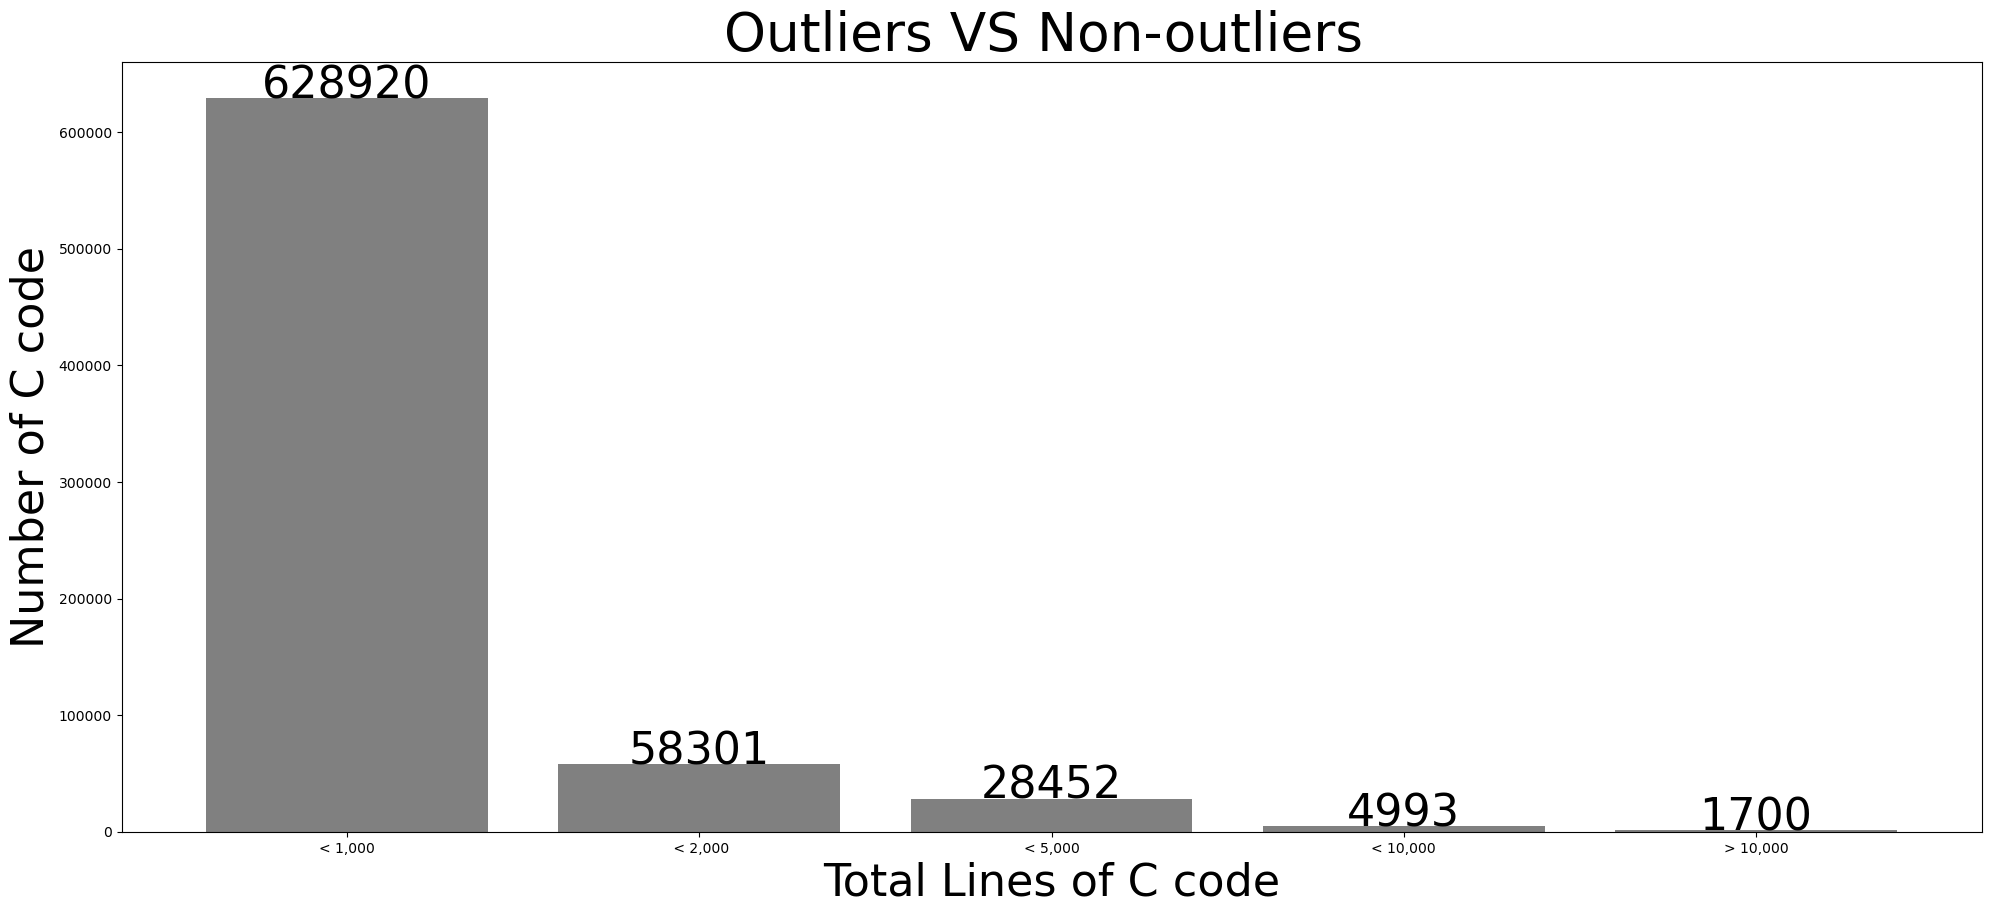

In [5]:
fig,ax = plt.subplots(figsize=(24,10)) 
plt.rcParams['font.size'] = 32
plt.title("Outliers VS Non-outliers ")
plt.ylabel('Number of C code',fontsize=32)
plt.xlabel('Total Lines of C code',fontsize=32)
#ax.set_xscale("log10")
plt.bar(my_ppa,my_app,color='grey')
addlabels(my_ppa, my_app)

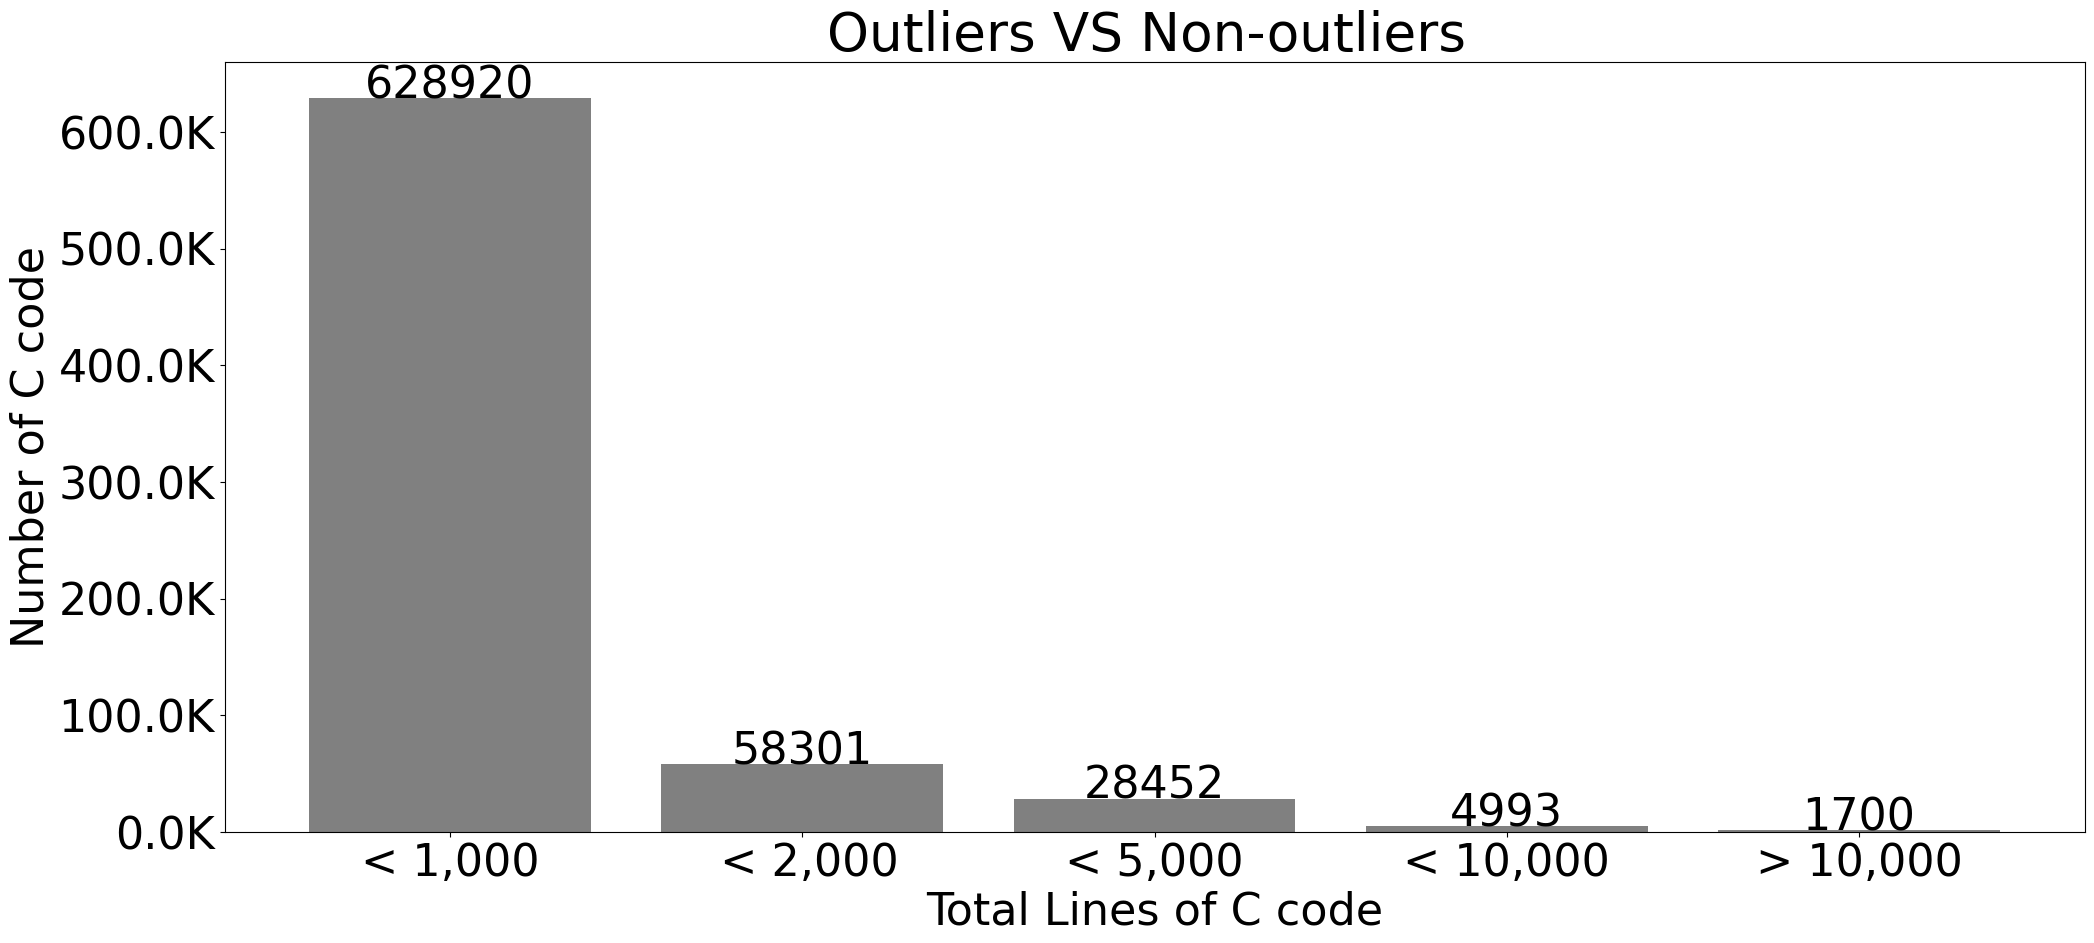

In [13]:
fig,ax = plt.subplots(figsize=(24,10)) 
plt.rcParams['font.size'] = 32
plt.title("Outliers VS Non-outliers ")
plt.ylabel('Number of C code',fontsize=32)
plt.xlabel('Total Lines of C code',fontsize=32)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.1f}'.format(y/1000) + 'K'))
plt.bar(my_ppa,my_app,color='grey')
addlabels(my_ppa, my_app)

---------
## Negative sample generation from all code snippets - Function args swap only
---------

In [11]:
def generate_function_args_swap_dataset(root_dir):
    total_files, total_samples = 0, 0
    global current_file
    
    with open("a0a0afunction_swap_samples.txt", 'a') as function_swap_samples:
        # function_swap_samples.write("function_name,arg1,arg2,arg_type,param1,param2,labels")
        
        for root, dirs, files in os.walk(root_dir):
                for file in files:
                    if file.endswith(".c"):
                        total_files += 1

                        file_path = os.path.join(root, file)
                        current_file = file_path

                        if total_files > 46000:
                            with open(file_path, 'rb') as f:
                                content = str(f.read())

                                if content.count("\\n") <= 10_000:
                                    start_cursor = index.parse(file_path).cursor

                                    function_list = []
                                    get_called_functions(start_cursor, start_cursor, function_list)

                                    for function in function_list:

                                        if len(function["args"]) == 2 and \
                                            (function["args"][0]["data_type"] == function["args"][1]["data_type"]) and \
                                            (function["args"][0]["name"] != function["args"][1]["name"]):

                                            positive_sample = [function["name"], function["args"][0]["name"], function["args"][1]["name"],
                                                              function["return_type"]]

                                            if(len(function["params"]) == 2):
                                                positive_sample.append(function["params"][0]["name"])
                                                positive_sample.append(function["params"][1]["name"])
                                            else:
                                                positive_sample.append("")
                                                positive_sample.append("")

                                            negative_sample = deepcopy(positive_sample)
                                            # swap
                                            negative_sample[1], negative_sample[2] = negative_sample[2], negative_sample[1]

                                            positive_sample.append(str(0))
                                            negative_sample.append(str(1))

                                            positive_sample = ",".join(positive_sample)
                                            negative_sample = ",".join(negative_sample)

                                            function_swap_samples.write("\n" + positive_sample)
                                            function_swap_samples.write("\n" + negative_sample)

                                            total_samples += 1

                        # current_file = file_path

                        if total_files % 1000 == 0:
                            print("Total files:", total_files, ",", "Total samples:", total_samples)

In [1]:
root_dir = 'D:\\c code corpus cleaned\\'

generate_function_args_swap_dataset(root_dir)

NameError: name 'generate_function_args_swap_dataset' is not defined

In [13]:
# current_file